# Cirq

In [ ]:
import cirq
from cirq.contrib.svg import SVGCircuit

def get_cirq_compilation(qasm_qc, target):
    if "ibm" in target:
        pass
    elif "rigetti" in target:
        pass
    elif "ionq" in target:
        pass

In [ ]:
from cirq.contrib.qasm_import import circuit_from_qasm
test = open('../MQTbench/mqt/bench/qasm_output/su2random_indep_4.qasm', 'r').read()
ion_circuit = cirq.ion.ConvertToIonGates().convert_circuit(circuit)
print(ion_circuit)

In [ ]:
import cirq_rigetti
c = cirq_rigetti.circuit_transformers.default(circuit=circuit)
print(c)

SVGCircuit(c[0])

In [ ]:
import cirq
import cirq_ionq as ionq
q0 = cirq.LineQubit(0)
device = ionq.IonQAPIDevice([q0])
circuit = cirq.Circuit(device=device)
circuit.append(cirq.H(q0)**0.2) # Non-IonQ-API gate
print(circuit) # will print the circuit converted into IonQ's target gateset

# Pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
ibm_native_gates = FakeMontreal().configuration().basis_gates
rigetti_native_gates = ["rx", "rz", "cz"]
ibm_native_gates

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

compiled_qfunc = qml.compile(basis_set=rigetti_native_gates)(qfunc)
compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

In [ ]:
path_file = "../MQTbench/qasm_output/dj_indep_4.qasm"
with open (path_file, "r") as myfile:
    data = myfile.read()
my_circuit = qml.from_qasm(data)

n=4
dev = qml.device('default.qubit', wires=n)
@qml.qnode(dev)
def circuit():
    my_circuit(wires=tuple(range(n)))
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

#circuit()
#print(dev._circuit.qasm(formatted=True))

In [ ]:
pennylane_ibm=["RZ", "SX", "PauliX", "CNOT"]
pennylane_rigetti=["RX", "RZ", "CZ"]

In [ ]:
compiled_qfunc1 = qml.compile()(circuit)
compiled_qnode1 = qml.QNode(compiled_qfunc1, dev)
print(qml.draw(compiled_qnode1)())

compiled_qfunc2 = qml.compile(
    basis_set=["CNOT", "RX", "RY", "RZ"],
    num_passes=2
)(circuit)

compiled_qnode2 = qml.QNode(compiled_qfunc2, dev)
print(qml.draw(compiled_qnode2)())

In [ ]:
def qfunc(x, y, z):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(z, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(z, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(x, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-z, wires=2)
    qml.RX(y, wires=2)
    qml.PauliY(wires=2)
    qml.CY(wires=[1, 2])
    return qml.expval(qml.PauliZ(wires=0))

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

compiled_qfunc = qml.compile(
    pipeline=[
        qml.transforms.commute_controlled(direction="left"),
        qml.transforms.merge_rotations(atol=1e-6),
        qml.transforms.cancel_inverses
    ],
    basis_set=["CNOT", "RX", "RY", "CZ"],
    num_passes=2
)(qfunc)

compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

In [ ]:
def qfunc():
    qml.Hadamard(wires=0)    
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(-0.4, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(-0.4, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(-0.4, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-0.4, wires=2)
    qml.RX(1, wires=2)
    qml.PauliY(wires=2)
    qml.CY(wires=[1, 2])
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)())

compiled_qfunc = qml.compile(
    basis_set=["CNOT", "Rdawd", "wdfawdaw", "dawd"],
    num_passes=20
)(qfunc)

compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)())

# Machine Learning Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])

# Feature Vector Generation

In [1]:
from mqt.bench import benchmark_generator
import matplotlib.pyplot as plt
from evaluator.qiskit_plugin import *
from evaluator.pytket_plugin import *
import numpy as np

ModuleNotFoundError: No module named 'utils'

In [ ]:
from evaluator.utils import get_openqasm_gates
def dict_to_featurevector(gate_dict):
    openqasm_gates_list = get_openqasm_gates()
    res_dct = {openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))}
    res_dct = dict.fromkeys(res_dct, 0)
    for key, val in dict(gate_dict).items():
        if not key in res_dct:
            print(key, "gate not found in openQASM 2.0 gateset")
        else:
            res_dct[key] = val
    return res_dct

In [3]:
benchmarks = ["dj", "ghz", "wstate", "graphstate", "ae", "qpeexact", "twolocalrandom", "qft", "qftentangled", "su2random" ]
res = []
for benchmark in benchmarks:
    for num_qubits in range(3,50,5):
        print(benchmark, num_qubits)
        qc = benchmark_generator.get_one_benchmark(benchmark, 1, num_qubits)
        qasm_qc = qc.qasm()
        ops_list = qc.count_ops()
        try:
            best_arch = np.argmin(get_tket_scores(qasm_qc)+get_qiskit_scores(qasm_qc))
            res.append((ops_list, best_arch, num_qubits))
        except Exception as e:
            print("fail: ", e)

dj 3


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Scores TKET:  [35.78332480818415, 11534.627831715208, 2.575, 40.02833864682961, 32.1285140562249]
Scores qiskit:  [33.058312020460356, 49.95069053708439, 0.2, 103.79029401346085, 110.11317999269806]
dj 8
Scores TKET:  [164.20245524296672, 109280.35329018338, 8.825, 204.39249025859016, 94.92515516611903]
Scores qiskit:  [196.35130434782607, 176.28030690537082, 0.2, 1610.3436060928088, 393.7203358890106]
dj 13
Scores TKET:  [282.2683375959079, 189797.74811218985, 100000, 404.8884165781084, 100000]
Scores qiskit:  [576.0665984654731, 299.431304347826, 100000, 3936.238044633369, 100000]
dj 18
Scores TKET:  [390.52552429667514, 304777.3597626753, 100000, 641.5161176053844, 100000]
Scores qiskit:  [817.4642455242965, 482.795294117647, 100000, 7778.958554729012, 100000]
dj 23
Scores TKET:  [538.5620460358056, 712866.3700107874, 100000, 1094.9344668792064, 100000]
Scores qiskit:  [910.0091048593348, 670.3371867007672, 100000, 8888.770811193765, 100000]
dj 28
Scores TKET:  [666.4366240409207, 1

Scores TKET:  [1964.4236317135546, 1844886.933656958, 97.4, 3787.4601487778955, 725.5202628696605]
Scores qiskit:  [853.7921227621482, 1399.9790281329922, 1.1, 3661.707403471484, 1845.052939028843]
twolocalrandom 13
Scores TKET:  [5373.416777493605, 5017110.881877022, 100000, 10896.918172157279, 100000]
Scores qiskit:  [1778.7859846547312, 2590.619437340153, 100000, 6969.8901877435355, 100000]
twolocalrandom 18
Scores TKET:  [10184.477340153451, 10378743.932038834, 100000, 21547.29011689692, 100000]
Scores qiskit:  [4266.052583120204, 6848.952838874679, 100000, 12392.490258590151, 100000]
twolocalrandom 23
Scores TKET:  [21651.13503836317, 17240208.414239485, 100000, 35449.52178533476, 100000]
Scores qiskit:  [7006.160306905369, 11649.021278772378, 100000, 16936.94651080411, 100000]
twolocalrandom 28
Scores TKET:  [33354.28603580562, 100000, 100000, 52242.2954303932, 100000]
Scores qiskit:  [12872.447161125318, 100000, 100000, 26154.799858306767, 100000]
twolocalrandom 33
Scores TKET: 

In [7]:
training_data = []
for elem in res:
    tmp=dict_to_featurevector(elem[0])
    tmp["num_qubits"]= elem[2]
    training_data.append((list(tmp.values()), elem[1]))
print(training_data)

measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
barrier gate not found in openQASM 2.0 gateset
measure gate not found in openQASM 2.0 gateset
barrier gate 

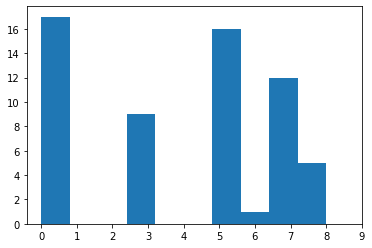

In [8]:
best_machine_index = []
for elem in res:
    best_machine_index.append(elem[1])
plt.hist(best_machine_index)
plt.xticks([0,1,2,3,4,5,6,7,8,9]);

In [10]:
x_train, y_train = zip(*training_data)
with open('x_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, x_train)
with open('y_train.csv', 'w') as FOUT:
    np.savetxt(FOUT, y_train)

In [11]:
print(y_train)

(7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 0, 6, 5, 5, 5, 5, 5, 3, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 5, 5, 8, 5, 8, 8, 8, 8)


In [12]:
from numpy import genfromtxt
X = genfromtxt('x_train.csv')
y = genfromtxt('y_train.csv')
print(X.shape, y.shape)

(60, 43) (60,)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

In [14]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, activation='relu', input_dim=43))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100)

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-03-30 16:18:46.175293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-30 16:18:46.175622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-30 16:18:46.287525: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 0s 34ms/step - loss: 21.0399 - accuracy: 0.1667
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 4.7609 - accuracy: 0.4524
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 2.6886 - accuracy: 0.4048
Epoch 4/100


2022-03-30 16:18:46.454032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 7ms/step - loss: 2.2957 - accuracy: 0.5238
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 2.2516 - accuracy: 0.5238
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 2.9626 - accuracy: 0.6905
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 2.7851 - accuracy: 0.6905
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1786 - accuracy: 0.6667
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 1.0774 - accuracy: 0.6905
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 1.0409 - accuracy: 0.6905
Epoch 11/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1719 - accuracy: 0.7143
Epoch 12/100
2/2 [==============================] - 0s 7ms/step - loss: 0.8280 - accuracy: 0.7381
Epoch 13/100
2/2 [==============================] - 0s 7ms/step - loss: 1.1113 - accuracy: 0.6905
Epoch 14/100
2/2 [====================

In [15]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

2022-03-30 16:18:55.440925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-30 16:18:55.534345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on training data: 0.8333333730697632% 
 Error on training data: 0.16666662693023682
Accuracy on test data: 0.7222222089767456% 
 Error on test data: 0.2777777910232544


# TKET IonQ Custom Rebase Pass

In [ ]:
import pytket
from pytket import OpType, circuit, _tket, Circuit
from pytket.passes import RebaseCustom

In [ ]:
gates = {OpType.Rz, OpType.Ry, OpType.CY, OpType.ZZPhase}
cx_in_cy = Circuit(2)
cx_in_cy.Rz(0.5, 1).CY(0, 1).Rz(-0.5, 1)
def tk1_to_rzry(a, b, c):
    circ = Circuit(1)
    circ.Rz(c + 0.5, 0).Ry(b, 0).Rz(a - 0.5, 0)
    return circ

custom = RebaseCustom(gates, cx_in_cy, tk1_to_rzry)

circ = Circuit(3)
circ.X(0).CX(0, 1).Ry(0.2, 1)
circ.add_gate(OpType.ZZPhase, -0.83, [2, 1]).Rx(0.6, 2)

custom.apply(circ)

print(circ.get_commands())

In [ ]:
ionq_gateset = {OpType.Rz, OpType.Ry, OpType.XXPhase}
cx_in_ionq = _tket.circuit._library._CX_using_XXPhase_0()
def tk1_to_rzry(a, b, c):
    circ = Circuit(1)
    circ.Rz(c + 0.5, 0).Ry(b, 0).Rz(a - 0.5, 0)
    return circ
ionq_rebase = RebaseCustom(ionq_gateset, cx_in_ionq, tk1_to_rzry)

In [ ]:
circ = Circuit(3)
circ.X(0).CX(0, 1).Ry(0.2, 1)
circ.add_gate(OpType.ZZPhase, -0.83, [2, 1]).Rx(0.6, 2)

ionq_rebase.apply(circ)
print(circ.get_commands())

In [ ]:
from pytket._tket.circuit._library._CX_using_XXPhase_0()

In [ ]:
_library._CX_using_XXPhase_0()

# Testing/Debugging

In [9]:
from evaluator import utils
from pytket.circuit.display import render_circuit_jupyter
from mqt.bench import benchmark_generator
import matplotlib.pyplot as plt
from evaluator.qiskit_plugin import *
from evaluator.pytket_plugin import *
import numpy as np
from pytket.extensions.qiskit import qiskit_to_tk
from qiskit import QuantumCircuit

In [19]:
qc_raw = benchmark_generator.get_one_benchmark("dj", 1, 5)
qasm_qc = qc_raw.qasm()
qc = qasm.circuit_from_qasm_str(qasm_qc)
render_circuit_jupyter(qc)

In [20]:
from pytket.extensions.qiskit import qiskit_to_tk
qc = qiskit_to_tk(qc_raw)
render_circuit_jupyter(qc)

In [22]:

from pytket import pytket_qiskit

ImportError: cannot import name 'pytket_qiskit' from 'pytket' (/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/pytket/__init__.py)